In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras
import random
import tensorflow as tf
import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (2,) #  (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 1

        optimizer = Adam(0.0002, 0.9)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):
        
        
        model = Sequential(name='Generator')
        with tf.name_scope('Generator'):
            model.add(Dense(50, input_dim=self.latent_dim,name='g_fc_1'))
            model.add(LeakyReLU(alpha=0.2))
#             model.add(BatchNormalization(momentum=0.8, name='g_bn_1'))
            model.add(Dense(200, name='g_fc_2'))
            model.add(LeakyReLU(alpha=0.2))
#             model.add(BatchNormalization(momentum=0.8,name='g_bn_2'))
            model.add(Dense(np.prod(self.img_shape),name='fc_3'))
            model.add(Reshape(self.img_shape))

            model.summary()

            noise = Input(shape=(self.latent_dim,))
            img = model(noise)

            return Model(noise, img)

    def build_discriminator(self):

        model = Sequential(name='Discriminator')

        with tf.name_scope('Discriminator'):
            #model.add(Flatten(input_shape=self.img_shape))
            model.add(Dense(200, input_shape=self.img_shape, name='d_fc_1'))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(50, name='d_fc_2'))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(1, activation='sigmoid', name='Discriminate'))
            model.summary()

            img = Input(shape=self.img_shape)
            validity = model(img)

            return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
#         (X_train, _), (_, _) = mnist.load_data()

        def sample_toy_distr():
            x = np.random.normal(0, 0.1)
            y = np.random.normal(0, 0.1)
            centers = [(0,2), (2,0), (2,2)]
            mu_x, mu_y = random.sample(centers,1)[0]
            return [x + mu_x, y + mu_y]

        def sample_data(batch_size):
            return np.array([sample_toy_distr() for _ in range(batch_size)])


        # Rescale -1 to 1
#         X_train = X_train / 127.5 - 1.
#         X_train = np.expand_dims(X_train, axis=3)
        X_train = sample_data(batch_size*5000)
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        tensorboard = keras.callbacks.TensorBoard(log_dir='./keras-output', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
        tensorboard.set_model(self.combined)
        # Transform train_on_batch return value
        # to dict expected by on_batch_end callback
        def write_log(callback, name, value, batch_no):
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value
            summary_value.tag = name
            callback.writer.add_summary(summary, batch_no)
            callback.writer.flush()
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
            log = {'g_loss': g_loss, 'd_loss': d_loss}
            
            write_log(tensorboard, 'g_loss', g_loss, epoch)
            write_log(tensorboard, 'd_loss', d_loss[0], epoch)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
            

    def sample_images(self, epoch):
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
#         print(gen_imgs)
        return gen_imgs

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


Using TensorFlow backend.


In [2]:
gan = GAN()
gan.train(epochs=5000, batch_size=32, sample_interval=200)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_fc_1 (Dense)               (None, 200)               600       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
d_fc_2 (Dense)               (None, 50)                10050     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
Discriminate (Dense)         (None, 1)                 51        
Total params: 10,701
Trainable params: 10,701
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g_fc_1

/home/nil/Apps/Anaconda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.644384, acc.: 48.44%] [G loss: 0.688189]
1 [D loss: 0.639584, acc.: 50.00%] [G loss: 0.686899]
2 [D loss: 0.636003, acc.: 50.00%] [G loss: 0.683657]
3 [D loss: 0.609912, acc.: 50.00%] [G loss: 0.685613]
4 [D loss: 0.616791, acc.: 50.00%] [G loss: 0.682427]
5 [D loss: 0.605885, acc.: 50.00%] [G loss: 0.682401]
6 [D loss: 0.599931, acc.: 50.00%] [G loss: 0.682073]
7 [D loss: 0.606509, acc.: 50.00%] [G loss: 0.678302]
8 [D loss: 0.586422, acc.: 50.00%] [G loss: 0.680485]
9 [D loss: 0.582166, acc.: 50.00%] [G loss: 0.682095]
10 [D loss: 0.572881, acc.: 50.00%] [G loss: 0.673016]
11 [D loss: 0.580891, acc.: 50.00%] [G loss: 0.672423]
12 [D loss: 0.571759, acc.: 50.00%] [G loss: 0.668831]
13 [D loss: 0.566858, acc.: 50.00%] [G loss: 0.670248]
14 [D loss: 0.563288, acc.: 50.00%] [G loss: 0.662346]
15 [D loss: 0.546997, acc.: 50.00%] [G loss: 0.664344]
16 [D loss: 0.550376, acc.: 50.00%] [G loss: 0.665096]
17 [D loss: 0.546901, acc.: 50.00%] [G loss: 0.656907]
18 [D loss: 0.550795

153 [D loss: 0.822431, acc.: 32.81%] [G loss: 0.897070]
154 [D loss: 0.716194, acc.: 48.44%] [G loss: 0.848105]
155 [D loss: 0.706244, acc.: 51.56%] [G loss: 0.856270]
156 [D loss: 0.717768, acc.: 54.69%] [G loss: 0.748866]
157 [D loss: 0.748206, acc.: 45.31%] [G loss: 0.826570]
158 [D loss: 0.717311, acc.: 50.00%] [G loss: 0.787035]
159 [D loss: 0.734418, acc.: 46.88%] [G loss: 0.794041]
160 [D loss: 0.731299, acc.: 43.75%] [G loss: 0.733442]
161 [D loss: 0.713710, acc.: 48.44%] [G loss: 0.770401]
162 [D loss: 0.676832, acc.: 53.12%] [G loss: 0.812695]
163 [D loss: 0.740312, acc.: 42.19%] [G loss: 0.809330]
164 [D loss: 0.713813, acc.: 50.00%] [G loss: 0.817503]
165 [D loss: 0.697726, acc.: 51.56%] [G loss: 0.791260]
166 [D loss: 0.708032, acc.: 43.75%] [G loss: 0.762054]
167 [D loss: 0.725212, acc.: 40.62%] [G loss: 0.720767]
168 [D loss: 0.692309, acc.: 45.31%] [G loss: 0.803672]
169 [D loss: 0.675828, acc.: 39.06%] [G loss: 0.730100]
170 [D loss: 0.697705, acc.: 39.06%] [G loss: 0.

305 [D loss: 0.688581, acc.: 50.00%] [G loss: 0.844790]
306 [D loss: 0.669418, acc.: 50.00%] [G loss: 0.858323]
307 [D loss: 0.673625, acc.: 50.00%] [G loss: 0.849700]
308 [D loss: 0.683928, acc.: 50.00%] [G loss: 0.842172]
309 [D loss: 0.671326, acc.: 50.00%] [G loss: 0.843259]
310 [D loss: 0.673111, acc.: 50.00%] [G loss: 0.842993]
311 [D loss: 0.686042, acc.: 50.00%] [G loss: 0.857323]
312 [D loss: 0.686392, acc.: 50.00%] [G loss: 0.852840]
313 [D loss: 0.676451, acc.: 50.00%] [G loss: 0.839458]
314 [D loss: 0.687769, acc.: 50.00%] [G loss: 0.852165]
315 [D loss: 0.672828, acc.: 50.00%] [G loss: 0.865426]
316 [D loss: 0.655420, acc.: 50.00%] [G loss: 0.868998]
317 [D loss: 0.658429, acc.: 50.00%] [G loss: 0.854555]
318 [D loss: 0.676160, acc.: 51.56%] [G loss: 0.865004]
319 [D loss: 0.677651, acc.: 50.00%] [G loss: 0.851941]
320 [D loss: 0.661426, acc.: 54.69%] [G loss: 0.871213]
321 [D loss: 0.662113, acc.: 54.69%] [G loss: 0.865793]
322 [D loss: 0.676590, acc.: 51.56%] [G loss: 0.

458 [D loss: 0.493101, acc.: 89.06%] [G loss: 0.878923]
459 [D loss: 0.527847, acc.: 82.81%] [G loss: 0.885631]
460 [D loss: 0.532066, acc.: 82.81%] [G loss: 0.899393]
461 [D loss: 0.523425, acc.: 84.38%] [G loss: 0.873577]
462 [D loss: 0.542034, acc.: 82.81%] [G loss: 0.880165]
463 [D loss: 0.550415, acc.: 81.25%] [G loss: 0.902058]
464 [D loss: 0.592337, acc.: 75.00%] [G loss: 0.863048]
465 [D loss: 0.583108, acc.: 76.56%] [G loss: 0.871505]
466 [D loss: 0.551430, acc.: 78.12%] [G loss: 0.856517]
467 [D loss: 0.512790, acc.: 84.38%] [G loss: 0.861808]
468 [D loss: 0.536611, acc.: 82.81%] [G loss: 0.841285]
469 [D loss: 0.517357, acc.: 84.38%] [G loss: 0.843865]
470 [D loss: 0.503744, acc.: 85.94%] [G loss: 0.825257]
471 [D loss: 0.555027, acc.: 81.25%] [G loss: 0.834716]
472 [D loss: 0.574349, acc.: 79.69%] [G loss: 0.800016]
473 [D loss: 0.571669, acc.: 76.56%] [G loss: 0.810712]
474 [D loss: 0.545193, acc.: 78.12%] [G loss: 0.803692]
475 [D loss: 0.521587, acc.: 82.81%] [G loss: 0.

613 [D loss: 0.667870, acc.: 53.12%] [G loss: 0.778118]
614 [D loss: 0.607698, acc.: 67.19%] [G loss: 0.730622]
615 [D loss: 0.606485, acc.: 70.31%] [G loss: 0.748916]
616 [D loss: 0.658116, acc.: 57.81%] [G loss: 0.769168]
617 [D loss: 0.645708, acc.: 60.94%] [G loss: 0.759200]
618 [D loss: 0.585474, acc.: 62.50%] [G loss: 0.718657]
619 [D loss: 0.648774, acc.: 56.25%] [G loss: 0.738357]
620 [D loss: 0.610625, acc.: 62.50%] [G loss: 0.699526]
621 [D loss: 0.588122, acc.: 73.44%] [G loss: 0.714121]
622 [D loss: 0.655259, acc.: 64.06%] [G loss: 0.725398]
623 [D loss: 0.623638, acc.: 64.06%] [G loss: 0.635442]
624 [D loss: 0.598788, acc.: 68.75%] [G loss: 0.674060]
625 [D loss: 0.662611, acc.: 56.25%] [G loss: 0.673256]
626 [D loss: 0.667151, acc.: 59.38%] [G loss: 0.686242]
627 [D loss: 0.620216, acc.: 65.62%] [G loss: 0.689311]
628 [D loss: 0.622226, acc.: 62.50%] [G loss: 0.617722]
629 [D loss: 0.622416, acc.: 64.06%] [G loss: 0.652200]
630 [D loss: 0.669479, acc.: 59.38%] [G loss: 0.

765 [D loss: 0.561545, acc.: 82.81%] [G loss: 0.852297]
766 [D loss: 0.579753, acc.: 79.69%] [G loss: 0.810328]
767 [D loss: 0.558526, acc.: 81.25%] [G loss: 0.818013]
768 [D loss: 0.579150, acc.: 81.25%] [G loss: 0.792997]
769 [D loss: 0.584132, acc.: 78.12%] [G loss: 0.791588]
770 [D loss: 0.585367, acc.: 73.44%] [G loss: 0.786241]
771 [D loss: 0.572309, acc.: 79.69%] [G loss: 0.771108]
772 [D loss: 0.604502, acc.: 73.44%] [G loss: 0.771496]
773 [D loss: 0.641452, acc.: 62.50%] [G loss: 0.738504]
774 [D loss: 0.555938, acc.: 75.00%] [G loss: 0.717830]
775 [D loss: 0.697498, acc.: 64.06%] [G loss: 0.725990]
776 [D loss: 0.635916, acc.: 64.06%] [G loss: 0.718692]
777 [D loss: 0.588630, acc.: 62.50%] [G loss: 0.733680]
778 [D loss: 0.592169, acc.: 71.88%] [G loss: 0.670383]
779 [D loss: 0.627503, acc.: 64.06%] [G loss: 0.686204]
780 [D loss: 0.757456, acc.: 50.00%] [G loss: 0.683017]
781 [D loss: 0.640211, acc.: 60.94%] [G loss: 0.679473]
782 [D loss: 0.591134, acc.: 67.19%] [G loss: 0.

921 [D loss: 0.480152, acc.: 81.25%] [G loss: 0.942588]
922 [D loss: 0.484073, acc.: 84.38%] [G loss: 0.934882]
923 [D loss: 0.548395, acc.: 75.00%] [G loss: 0.927041]
924 [D loss: 0.495320, acc.: 82.81%] [G loss: 0.895279]
925 [D loss: 0.497431, acc.: 81.25%] [G loss: 0.938013]
926 [D loss: 0.544641, acc.: 76.56%] [G loss: 0.926701]
927 [D loss: 0.528542, acc.: 79.69%] [G loss: 0.895019]
928 [D loss: 0.559036, acc.: 76.56%] [G loss: 0.911106]
929 [D loss: 0.465753, acc.: 87.50%] [G loss: 0.901934]
930 [D loss: 0.499269, acc.: 84.38%] [G loss: 0.873039]
931 [D loss: 0.512183, acc.: 76.56%] [G loss: 0.863566]
932 [D loss: 0.530100, acc.: 78.12%] [G loss: 0.872208]
933 [D loss: 0.565509, acc.: 68.75%] [G loss: 0.936899]
934 [D loss: 0.586061, acc.: 71.88%] [G loss: 0.814839]
935 [D loss: 0.522551, acc.: 75.00%] [G loss: 0.876496]
936 [D loss: 0.483091, acc.: 85.94%] [G loss: 0.857452]
937 [D loss: 0.480131, acc.: 81.25%] [G loss: 0.834400]
938 [D loss: 0.543364, acc.: 70.31%] [G loss: 0.

1076 [D loss: 0.599364, acc.: 59.38%] [G loss: 1.025938]
1077 [D loss: 0.549812, acc.: 70.31%] [G loss: 1.039573]
1078 [D loss: 0.551627, acc.: 62.50%] [G loss: 1.058120]
1079 [D loss: 0.508070, acc.: 76.56%] [G loss: 1.021852]
1080 [D loss: 0.527082, acc.: 73.44%] [G loss: 1.082536]
1081 [D loss: 0.532134, acc.: 78.12%] [G loss: 1.075841]
1082 [D loss: 0.511979, acc.: 82.81%] [G loss: 1.057709]
1083 [D loss: 0.516409, acc.: 79.69%] [G loss: 1.083407]
1084 [D loss: 0.525909, acc.: 82.81%] [G loss: 1.132293]
1085 [D loss: 0.512230, acc.: 82.81%] [G loss: 1.110144]
1086 [D loss: 0.510281, acc.: 82.81%] [G loss: 1.039214]
1087 [D loss: 0.544580, acc.: 81.25%] [G loss: 1.054042]
1088 [D loss: 0.541851, acc.: 76.56%] [G loss: 1.061292]
1089 [D loss: 0.488667, acc.: 84.38%] [G loss: 1.092561]
1090 [D loss: 0.549481, acc.: 81.25%] [G loss: 1.058629]
1091 [D loss: 0.564584, acc.: 78.12%] [G loss: 1.048728]
1092 [D loss: 0.533608, acc.: 85.94%] [G loss: 1.112659]
1093 [D loss: 0.517681, acc.: 8

1229 [D loss: 0.830826, acc.: 35.94%] [G loss: 0.765394]
1230 [D loss: 0.767236, acc.: 54.69%] [G loss: 0.764270]
1231 [D loss: 0.736515, acc.: 57.81%] [G loss: 0.788563]
1232 [D loss: 0.754752, acc.: 54.69%] [G loss: 0.763823]
1233 [D loss: 0.748486, acc.: 54.69%] [G loss: 0.756017]
1234 [D loss: 0.765699, acc.: 54.69%] [G loss: 0.785526]
1235 [D loss: 0.772097, acc.: 51.56%] [G loss: 0.789837]
1236 [D loss: 0.750494, acc.: 45.31%] [G loss: 0.764597]
1237 [D loss: 0.766684, acc.: 50.00%] [G loss: 0.761956]
1238 [D loss: 0.763524, acc.: 48.44%] [G loss: 0.833950]
1239 [D loss: 0.755836, acc.: 51.56%] [G loss: 0.773404]
1240 [D loss: 0.747552, acc.: 54.69%] [G loss: 0.799245]
1241 [D loss: 0.711712, acc.: 56.25%] [G loss: 0.697797]
1242 [D loss: 0.730154, acc.: 48.44%] [G loss: 0.829575]
1243 [D loss: 0.735500, acc.: 46.88%] [G loss: 0.795393]
1244 [D loss: 0.774630, acc.: 42.19%] [G loss: 0.845863]
1245 [D loss: 0.759502, acc.: 42.19%] [G loss: 0.823389]
1246 [D loss: 0.733839, acc.: 4

1381 [D loss: 0.663143, acc.: 65.62%] [G loss: 0.888219]
1382 [D loss: 0.661732, acc.: 70.31%] [G loss: 0.883053]
1383 [D loss: 0.657943, acc.: 68.75%] [G loss: 0.876829]
1384 [D loss: 0.665024, acc.: 65.62%] [G loss: 0.896405]
1385 [D loss: 0.665270, acc.: 65.62%] [G loss: 0.859767]
1386 [D loss: 0.662139, acc.: 65.62%] [G loss: 0.880030]
1387 [D loss: 0.678640, acc.: 60.94%] [G loss: 0.867666]
1388 [D loss: 0.677526, acc.: 59.38%] [G loss: 0.896675]
1389 [D loss: 0.681137, acc.: 60.94%] [G loss: 0.876781]
1390 [D loss: 0.680310, acc.: 60.94%] [G loss: 0.879192]
1391 [D loss: 0.658443, acc.: 70.31%] [G loss: 0.865418]
1392 [D loss: 0.667306, acc.: 64.06%] [G loss: 0.860817]
1393 [D loss: 0.645852, acc.: 75.00%] [G loss: 0.872058]
1394 [D loss: 0.664873, acc.: 62.50%] [G loss: 0.872583]
1395 [D loss: 0.663192, acc.: 67.19%] [G loss: 0.879403]
1396 [D loss: 0.676761, acc.: 57.81%] [G loss: 0.869006]
1397 [D loss: 0.651567, acc.: 68.75%] [G loss: 0.862799]
1398 [D loss: 0.666790, acc.: 6

1530 [D loss: 0.638468, acc.: 64.06%] [G loss: 0.774476]
1531 [D loss: 0.635415, acc.: 64.06%] [G loss: 0.768691]
1532 [D loss: 0.640374, acc.: 64.06%] [G loss: 0.771125]
1533 [D loss: 0.619498, acc.: 68.75%] [G loss: 0.779750]
1534 [D loss: 0.631132, acc.: 64.06%] [G loss: 0.774012]
1535 [D loss: 0.650446, acc.: 62.50%] [G loss: 0.768852]
1536 [D loss: 0.640475, acc.: 62.50%] [G loss: 0.780980]
1537 [D loss: 0.624507, acc.: 68.75%] [G loss: 0.759707]
1538 [D loss: 0.635662, acc.: 70.31%] [G loss: 0.769386]
1539 [D loss: 0.637844, acc.: 65.62%] [G loss: 0.787652]
1540 [D loss: 0.630479, acc.: 70.31%] [G loss: 0.767391]
1541 [D loss: 0.610905, acc.: 73.44%] [G loss: 0.758039]
1542 [D loss: 0.638624, acc.: 65.62%] [G loss: 0.772019]
1543 [D loss: 0.616522, acc.: 73.44%] [G loss: 0.763878]
1544 [D loss: 0.606472, acc.: 78.12%] [G loss: 0.763345]
1545 [D loss: 0.635553, acc.: 68.75%] [G loss: 0.761530]
1546 [D loss: 0.633226, acc.: 78.12%] [G loss: 0.762301]
1547 [D loss: 0.650447, acc.: 6

1688 [D loss: 0.536554, acc.: 73.44%] [G loss: 0.785696]
1689 [D loss: 0.601966, acc.: 62.50%] [G loss: 0.780730]
1690 [D loss: 0.532031, acc.: 73.44%] [G loss: 0.782995]
1691 [D loss: 0.573813, acc.: 67.19%] [G loss: 0.778922]
1692 [D loss: 0.610062, acc.: 60.94%] [G loss: 0.777973]
1693 [D loss: 0.617752, acc.: 59.38%] [G loss: 0.776484]
1694 [D loss: 0.583130, acc.: 65.62%] [G loss: 0.781724]
1695 [D loss: 0.560867, acc.: 68.75%] [G loss: 0.779196]
1696 [D loss: 0.543380, acc.: 71.88%] [G loss: 0.780122]
1697 [D loss: 0.584597, acc.: 64.06%] [G loss: 0.777481]
1698 [D loss: 0.542143, acc.: 71.88%] [G loss: 0.775313]
1699 [D loss: 0.568805, acc.: 67.19%] [G loss: 0.776072]
1700 [D loss: 0.617087, acc.: 59.38%] [G loss: 0.780198]
1701 [D loss: 0.572143, acc.: 67.19%] [G loss: 0.767627]
1702 [D loss: 0.595046, acc.: 64.06%] [G loss: 0.770780]
1703 [D loss: 0.569473, acc.: 67.19%] [G loss: 0.766540]
1704 [D loss: 0.587209, acc.: 64.06%] [G loss: 0.764949]
1705 [D loss: 0.548680, acc.: 7

1843 [D loss: 0.670902, acc.: 65.62%] [G loss: 0.777241]
1844 [D loss: 0.665623, acc.: 65.62%] [G loss: 0.768480]
1845 [D loss: 0.636730, acc.: 75.00%] [G loss: 0.792533]
1846 [D loss: 0.657970, acc.: 71.88%] [G loss: 0.786174]
1847 [D loss: 0.655221, acc.: 67.19%] [G loss: 0.784337]
1848 [D loss: 0.665586, acc.: 67.19%] [G loss: 0.791797]
1849 [D loss: 0.667659, acc.: 64.06%] [G loss: 0.776818]
1850 [D loss: 0.643055, acc.: 75.00%] [G loss: 0.791730]
1851 [D loss: 0.641343, acc.: 76.56%] [G loss: 0.798726]
1852 [D loss: 0.658811, acc.: 68.75%] [G loss: 0.784291]
1853 [D loss: 0.648477, acc.: 73.44%] [G loss: 0.802018]
1854 [D loss: 0.679798, acc.: 60.94%] [G loss: 0.799768]
1855 [D loss: 0.682263, acc.: 60.94%] [G loss: 0.791489]
1856 [D loss: 0.675180, acc.: 64.06%] [G loss: 0.798772]
1857 [D loss: 0.666256, acc.: 64.06%] [G loss: 0.787019]
1858 [D loss: 0.672411, acc.: 65.62%] [G loss: 0.796717]
1859 [D loss: 0.674411, acc.: 60.94%] [G loss: 0.797440]
1860 [D loss: 0.661443, acc.: 7

1998 [D loss: 0.652296, acc.: 73.44%] [G loss: 0.813420]
1999 [D loss: 0.675574, acc.: 64.06%] [G loss: 0.791625]
2000 [D loss: 0.647394, acc.: 76.56%] [G loss: 0.812731]
2001 [D loss: 0.611356, acc.: 89.06%] [G loss: 0.791005]
2002 [D loss: 0.646298, acc.: 81.25%] [G loss: 0.813390]
2003 [D loss: 0.626238, acc.: 85.94%] [G loss: 0.796649]
2004 [D loss: 0.651274, acc.: 76.56%] [G loss: 0.819239]
2005 [D loss: 0.643149, acc.: 78.12%] [G loss: 0.778894]
2006 [D loss: 0.687012, acc.: 62.50%] [G loss: 0.802441]
2007 [D loss: 0.657299, acc.: 70.31%] [G loss: 0.803529]
2008 [D loss: 0.636983, acc.: 81.25%] [G loss: 0.819223]
2009 [D loss: 0.653736, acc.: 78.12%] [G loss: 0.819535]
2010 [D loss: 0.648374, acc.: 75.00%] [G loss: 0.771995]
2011 [D loss: 0.643776, acc.: 76.56%] [G loss: 0.802652]
2012 [D loss: 0.650616, acc.: 71.88%] [G loss: 0.805095]
2013 [D loss: 0.663993, acc.: 62.50%] [G loss: 0.760489]
2014 [D loss: 0.647461, acc.: 75.00%] [G loss: 0.783578]
2015 [D loss: 0.641211, acc.: 7

2152 [D loss: 0.596362, acc.: 67.19%] [G loss: 0.766515]
2153 [D loss: 0.576440, acc.: 70.31%] [G loss: 0.782526]
2154 [D loss: 0.585489, acc.: 73.44%] [G loss: 0.769596]
2155 [D loss: 0.565278, acc.: 78.12%] [G loss: 0.759724]
2156 [D loss: 0.603881, acc.: 75.00%] [G loss: 0.766726]
2157 [D loss: 0.591932, acc.: 78.12%] [G loss: 0.767171]
2158 [D loss: 0.599357, acc.: 71.88%] [G loss: 0.769385]
2159 [D loss: 0.599370, acc.: 75.00%] [G loss: 0.773674]
2160 [D loss: 0.591965, acc.: 78.12%] [G loss: 0.763596]
2161 [D loss: 0.620689, acc.: 73.44%] [G loss: 0.770472]
2162 [D loss: 0.607761, acc.: 71.88%] [G loss: 0.757506]
2163 [D loss: 0.601396, acc.: 78.12%] [G loss: 0.759414]
2164 [D loss: 0.592701, acc.: 81.25%] [G loss: 0.754457]
2165 [D loss: 0.591920, acc.: 85.94%] [G loss: 0.776977]
2166 [D loss: 0.626120, acc.: 73.44%] [G loss: 0.746517]
2167 [D loss: 0.579745, acc.: 76.56%] [G loss: 0.773681]
2168 [D loss: 0.573238, acc.: 75.00%] [G loss: 0.765957]
2169 [D loss: 0.579297, acc.: 8

2303 [D loss: 0.744580, acc.: 32.81%] [G loss: 0.717357]
2304 [D loss: 0.640967, acc.: 54.69%] [G loss: 0.636524]
2305 [D loss: 0.730339, acc.: 39.06%] [G loss: 0.670535]
2306 [D loss: 0.731964, acc.: 39.06%] [G loss: 0.682640]
2307 [D loss: 0.700249, acc.: 45.31%] [G loss: 0.696501]
2308 [D loss: 0.670403, acc.: 54.69%] [G loss: 0.691453]
2309 [D loss: 0.721523, acc.: 39.06%] [G loss: 0.631088]
2310 [D loss: 0.725108, acc.: 39.06%] [G loss: 0.662245]
2311 [D loss: 0.695745, acc.: 48.44%] [G loss: 0.686635]
2312 [D loss: 0.719054, acc.: 40.62%] [G loss: 0.654529]
2313 [D loss: 0.683403, acc.: 50.00%] [G loss: 0.651421]
2314 [D loss: 0.727676, acc.: 48.44%] [G loss: 0.655584]
2315 [D loss: 0.707539, acc.: 48.44%] [G loss: 0.661734]
2316 [D loss: 0.702737, acc.: 50.00%] [G loss: 0.659600]
2317 [D loss: 0.727001, acc.: 43.75%] [G loss: 0.644932]
2318 [D loss: 0.700475, acc.: 51.56%] [G loss: 0.652091]
2319 [D loss: 0.729321, acc.: 45.31%] [G loss: 0.682774]
2320 [D loss: 0.655725, acc.: 6

2457 [D loss: 0.639781, acc.: 68.75%] [G loss: 0.783687]
2458 [D loss: 0.612820, acc.: 71.88%] [G loss: 0.804557]
2459 [D loss: 0.615852, acc.: 71.88%] [G loss: 0.787524]
2460 [D loss: 0.623144, acc.: 76.56%] [G loss: 0.823825]
2461 [D loss: 0.582967, acc.: 76.56%] [G loss: 0.785120]
2462 [D loss: 0.618006, acc.: 71.88%] [G loss: 0.773152]
2463 [D loss: 0.608069, acc.: 75.00%] [G loss: 0.793746]
2464 [D loss: 0.624498, acc.: 68.75%] [G loss: 0.789102]
2465 [D loss: 0.591737, acc.: 76.56%] [G loss: 0.793685]
2466 [D loss: 0.633998, acc.: 71.88%] [G loss: 0.795000]
2467 [D loss: 0.639214, acc.: 62.50%] [G loss: 0.770739]
2468 [D loss: 0.627242, acc.: 71.88%] [G loss: 0.754202]
2469 [D loss: 0.592623, acc.: 71.88%] [G loss: 0.770841]
2470 [D loss: 0.619870, acc.: 76.56%] [G loss: 0.781889]
2471 [D loss: 0.622423, acc.: 78.12%] [G loss: 0.814267]
2472 [D loss: 0.626635, acc.: 70.31%] [G loss: 0.811002]
2473 [D loss: 0.609760, acc.: 85.94%] [G loss: 0.807239]
2474 [D loss: 0.594692, acc.: 8

2607 [D loss: 0.569759, acc.: 82.81%] [G loss: 0.773105]
2608 [D loss: 0.560629, acc.: 78.12%] [G loss: 0.779858]
2609 [D loss: 0.598304, acc.: 70.31%] [G loss: 0.742530]
2610 [D loss: 0.555665, acc.: 78.12%] [G loss: 0.789273]
2611 [D loss: 0.614742, acc.: 65.62%] [G loss: 0.761831]
2612 [D loss: 0.570784, acc.: 78.12%] [G loss: 0.766219]
2613 [D loss: 0.607544, acc.: 70.31%] [G loss: 0.775537]
2614 [D loss: 0.600977, acc.: 65.62%] [G loss: 0.764391]
2615 [D loss: 0.593571, acc.: 70.31%] [G loss: 0.802377]
2616 [D loss: 0.614358, acc.: 59.38%] [G loss: 0.781295]
2617 [D loss: 0.602340, acc.: 70.31%] [G loss: 0.814432]
2618 [D loss: 0.562008, acc.: 75.00%] [G loss: 0.812159]
2619 [D loss: 0.576603, acc.: 73.44%] [G loss: 0.795399]
2620 [D loss: 0.560512, acc.: 82.81%] [G loss: 0.771273]
2621 [D loss: 0.574065, acc.: 75.00%] [G loss: 0.819100]
2622 [D loss: 0.605287, acc.: 70.31%] [G loss: 0.788147]
2623 [D loss: 0.621864, acc.: 73.44%] [G loss: 0.807890]
2624 [D loss: 0.590852, acc.: 7

2754 [D loss: 0.545580, acc.: 81.25%] [G loss: 0.859634]
2755 [D loss: 0.510772, acc.: 82.81%] [G loss: 0.852519]
2756 [D loss: 0.578992, acc.: 81.25%] [G loss: 0.867806]
2757 [D loss: 0.565827, acc.: 76.56%] [G loss: 0.864414]
2758 [D loss: 0.539497, acc.: 78.12%] [G loss: 0.844278]
2759 [D loss: 0.493280, acc.: 82.81%] [G loss: 0.860079]
2760 [D loss: 0.530765, acc.: 78.12%] [G loss: 0.842591]
2761 [D loss: 0.527834, acc.: 75.00%] [G loss: 0.869798]
2762 [D loss: 0.553787, acc.: 68.75%] [G loss: 0.835435]
2763 [D loss: 0.523052, acc.: 73.44%] [G loss: 0.828444]
2764 [D loss: 0.531346, acc.: 70.31%] [G loss: 0.871220]
2765 [D loss: 0.529178, acc.: 68.75%] [G loss: 0.873351]
2766 [D loss: 0.542990, acc.: 67.19%] [G loss: 0.885864]
2767 [D loss: 0.552642, acc.: 65.62%] [G loss: 0.866763]
2768 [D loss: 0.503912, acc.: 73.44%] [G loss: 0.871895]
2769 [D loss: 0.567789, acc.: 62.50%] [G loss: 0.850212]
2770 [D loss: 0.589120, acc.: 60.94%] [G loss: 0.872239]
2771 [D loss: 0.501772, acc.: 7

2900 [D loss: 0.541672, acc.: 65.62%] [G loss: 0.878674]
2901 [D loss: 0.576347, acc.: 62.50%] [G loss: 0.903850]
2902 [D loss: 0.516953, acc.: 68.75%] [G loss: 0.896091]
2903 [D loss: 0.544610, acc.: 65.62%] [G loss: 0.937975]
2904 [D loss: 0.587779, acc.: 60.94%] [G loss: 0.883507]
2905 [D loss: 0.495109, acc.: 71.88%] [G loss: 0.902441]
2906 [D loss: 0.513047, acc.: 70.31%] [G loss: 0.881381]
2907 [D loss: 0.581839, acc.: 60.94%] [G loss: 0.893005]
2908 [D loss: 0.507202, acc.: 70.31%] [G loss: 0.903934]
2909 [D loss: 0.547297, acc.: 65.62%] [G loss: 0.918601]
2910 [D loss: 0.513680, acc.: 70.31%] [G loss: 0.891045]
2911 [D loss: 0.541248, acc.: 65.62%] [G loss: 0.893330]
2912 [D loss: 0.555967, acc.: 64.06%] [G loss: 0.888256]
2913 [D loss: 0.502971, acc.: 71.88%] [G loss: 0.904879]
2914 [D loss: 0.564910, acc.: 64.06%] [G loss: 0.906537]
2915 [D loss: 0.502834, acc.: 71.88%] [G loss: 0.896203]
2916 [D loss: 0.556904, acc.: 64.06%] [G loss: 0.893263]
2917 [D loss: 0.535518, acc.: 6

3054 [D loss: 0.640891, acc.: 59.38%] [G loss: 0.820702]
3055 [D loss: 0.644890, acc.: 57.81%] [G loss: 0.826270]
3056 [D loss: 0.633528, acc.: 59.38%] [G loss: 0.889461]
3057 [D loss: 0.608212, acc.: 64.06%] [G loss: 0.836180]
3058 [D loss: 0.634673, acc.: 53.12%] [G loss: 0.843890]
3059 [D loss: 0.615382, acc.: 64.06%] [G loss: 0.872250]
3060 [D loss: 0.648893, acc.: 56.25%] [G loss: 0.843147]
3061 [D loss: 0.619862, acc.: 60.94%] [G loss: 0.862432]
3062 [D loss: 0.627806, acc.: 56.25%] [G loss: 0.852897]
3063 [D loss: 0.649727, acc.: 54.69%] [G loss: 0.879804]
3064 [D loss: 0.605305, acc.: 67.19%] [G loss: 0.877551]
3065 [D loss: 0.606039, acc.: 65.62%] [G loss: 0.827756]
3066 [D loss: 0.618825, acc.: 64.06%] [G loss: 0.879999]
3067 [D loss: 0.604173, acc.: 68.75%] [G loss: 0.863497]
3068 [D loss: 0.600823, acc.: 67.19%] [G loss: 0.885318]
3069 [D loss: 0.617542, acc.: 64.06%] [G loss: 0.872668]
3070 [D loss: 0.604676, acc.: 65.62%] [G loss: 0.873398]
3071 [D loss: 0.603680, acc.: 7

3201 [D loss: 0.566189, acc.: 70.31%] [G loss: 0.844268]
3202 [D loss: 0.597588, acc.: 62.50%] [G loss: 0.858492]
3203 [D loss: 0.558001, acc.: 70.31%] [G loss: 0.851471]
3204 [D loss: 0.579392, acc.: 67.19%] [G loss: 0.871511]
3205 [D loss: 0.594625, acc.: 64.06%] [G loss: 0.852226]
3206 [D loss: 0.588824, acc.: 65.62%] [G loss: 0.856070]
3207 [D loss: 0.619172, acc.: 59.38%] [G loss: 0.828376]
3208 [D loss: 0.540679, acc.: 71.88%] [G loss: 0.798864]
3209 [D loss: 0.564183, acc.: 68.75%] [G loss: 0.854988]
3210 [D loss: 0.593453, acc.: 62.50%] [G loss: 0.803239]
3211 [D loss: 0.567164, acc.: 68.75%] [G loss: 0.860286]
3212 [D loss: 0.565236, acc.: 68.75%] [G loss: 0.858264]
3213 [D loss: 0.573416, acc.: 67.19%] [G loss: 0.835858]
3214 [D loss: 0.603524, acc.: 59.38%] [G loss: 0.839279]
3215 [D loss: 0.579481, acc.: 65.62%] [G loss: 0.844776]
3216 [D loss: 0.581750, acc.: 67.19%] [G loss: 0.843345]
3217 [D loss: 0.579523, acc.: 67.19%] [G loss: 0.846567]
3218 [D loss: 0.583182, acc.: 6

3360 [D loss: 0.599437, acc.: 60.94%] [G loss: 0.862061]
3361 [D loss: 0.553419, acc.: 65.62%] [G loss: 0.899373]
3362 [D loss: 0.536146, acc.: 68.75%] [G loss: 0.908433]
3363 [D loss: 0.533733, acc.: 68.75%] [G loss: 0.884083]
3364 [D loss: 0.499855, acc.: 73.44%] [G loss: 0.895365]
3365 [D loss: 0.554694, acc.: 65.62%] [G loss: 0.900410]
3366 [D loss: 0.557448, acc.: 64.06%] [G loss: 0.914473]
3367 [D loss: 0.540447, acc.: 67.19%] [G loss: 0.928696]
3368 [D loss: 0.535339, acc.: 68.75%] [G loss: 0.886366]
3369 [D loss: 0.534104, acc.: 67.19%] [G loss: 0.927054]
3370 [D loss: 0.583386, acc.: 60.94%] [G loss: 0.900102]
3371 [D loss: 0.539507, acc.: 67.19%] [G loss: 0.891590]
3372 [D loss: 0.558750, acc.: 65.62%] [G loss: 0.897653]
3373 [D loss: 0.594781, acc.: 60.94%] [G loss: 0.889675]
3374 [D loss: 0.526801, acc.: 70.31%] [G loss: 0.885930]
3375 [D loss: 0.559981, acc.: 65.62%] [G loss: 0.921529]
3376 [D loss: 0.518916, acc.: 70.31%] [G loss: 0.893549]
3377 [D loss: 0.546340, acc.: 6

3515 [D loss: 0.556071, acc.: 65.62%] [G loss: 0.935115]
3516 [D loss: 0.546525, acc.: 67.19%] [G loss: 0.930233]
3517 [D loss: 0.564045, acc.: 64.06%] [G loss: 0.898959]
3518 [D loss: 0.485372, acc.: 73.44%] [G loss: 0.933981]
3519 [D loss: 0.539269, acc.: 67.19%] [G loss: 0.911039]
3520 [D loss: 0.608065, acc.: 57.81%] [G loss: 0.953595]
3521 [D loss: 0.514722, acc.: 70.31%] [G loss: 0.895442]
3522 [D loss: 0.542882, acc.: 67.19%] [G loss: 0.915619]
3523 [D loss: 0.562358, acc.: 64.06%] [G loss: 0.910427]
3524 [D loss: 0.564663, acc.: 64.06%] [G loss: 0.927014]
3525 [D loss: 0.583541, acc.: 64.06%] [G loss: 0.921131]
3526 [D loss: 0.545028, acc.: 67.19%] [G loss: 0.905993]
3527 [D loss: 0.531177, acc.: 67.19%] [G loss: 0.911650]
3528 [D loss: 0.529643, acc.: 67.19%] [G loss: 0.880622]
3529 [D loss: 0.538325, acc.: 67.19%] [G loss: 0.918800]
3530 [D loss: 0.508828, acc.: 71.88%] [G loss: 0.933382]
3531 [D loss: 0.555311, acc.: 65.62%] [G loss: 0.933923]
3532 [D loss: 0.531727, acc.: 6

3675 [D loss: 0.576000, acc.: 64.06%] [G loss: 0.977433]
3676 [D loss: 0.566001, acc.: 64.06%] [G loss: 0.917852]
3677 [D loss: 0.542669, acc.: 67.19%] [G loss: 0.953003]
3678 [D loss: 0.511383, acc.: 70.31%] [G loss: 0.936103]
3679 [D loss: 0.602380, acc.: 60.94%] [G loss: 0.941724]
3680 [D loss: 0.535470, acc.: 68.75%] [G loss: 0.937953]
3681 [D loss: 0.516206, acc.: 70.31%] [G loss: 0.946976]
3682 [D loss: 0.560097, acc.: 67.19%] [G loss: 0.971648]
3683 [D loss: 0.576868, acc.: 64.06%] [G loss: 0.953583]
3684 [D loss: 0.480561, acc.: 75.00%] [G loss: 0.957550]
3685 [D loss: 0.504773, acc.: 71.88%] [G loss: 0.926416]
3686 [D loss: 0.604739, acc.: 60.94%] [G loss: 0.940964]
3687 [D loss: 0.574968, acc.: 64.06%] [G loss: 0.925215]
3688 [D loss: 0.564317, acc.: 65.62%] [G loss: 0.923714]
3689 [D loss: 0.565196, acc.: 65.62%] [G loss: 0.958442]
3690 [D loss: 0.507145, acc.: 70.31%] [G loss: 0.943766]
3691 [D loss: 0.535556, acc.: 68.75%] [G loss: 0.917929]
3692 [D loss: 0.543618, acc.: 6

3827 [D loss: 0.551627, acc.: 67.19%] [G loss: 0.891668]
3828 [D loss: 0.522122, acc.: 70.31%] [G loss: 0.930792]
3829 [D loss: 0.565073, acc.: 65.62%] [G loss: 0.922107]
3830 [D loss: 0.574656, acc.: 64.06%] [G loss: 0.890752]
3831 [D loss: 0.564577, acc.: 65.62%] [G loss: 0.940972]
3832 [D loss: 0.526829, acc.: 70.31%] [G loss: 0.934561]
3833 [D loss: 0.507396, acc.: 71.88%] [G loss: 0.913600]
3834 [D loss: 0.606976, acc.: 60.94%] [G loss: 0.930309]
3835 [D loss: 0.595520, acc.: 62.50%] [G loss: 0.874706]
3836 [D loss: 0.546848, acc.: 67.19%] [G loss: 0.913013]
3837 [D loss: 0.543193, acc.: 67.19%] [G loss: 0.933765]
3838 [D loss: 0.581946, acc.: 64.06%] [G loss: 0.879352]
3839 [D loss: 0.515075, acc.: 70.31%] [G loss: 0.913756]
3840 [D loss: 0.590978, acc.: 62.50%] [G loss: 0.878876]
3841 [D loss: 0.606854, acc.: 60.94%] [G loss: 0.900664]
3842 [D loss: 0.541732, acc.: 68.75%] [G loss: 0.925400]
3843 [D loss: 0.506567, acc.: 73.44%] [G loss: 0.902324]
3844 [D loss: 0.632340, acc.: 5

3974 [D loss: 0.577498, acc.: 67.19%] [G loss: 0.799020]
3975 [D loss: 0.584835, acc.: 70.31%] [G loss: 0.712546]
3976 [D loss: 0.598264, acc.: 68.75%] [G loss: 0.773199]
3977 [D loss: 0.582873, acc.: 62.50%] [G loss: 0.768188]
3978 [D loss: 0.602514, acc.: 62.50%] [G loss: 0.787276]
3979 [D loss: 0.603943, acc.: 60.94%] [G loss: 0.776381]
3980 [D loss: 0.582492, acc.: 73.44%] [G loss: 0.708041]
3981 [D loss: 0.575022, acc.: 71.88%] [G loss: 0.898653]
3982 [D loss: 0.588863, acc.: 68.75%] [G loss: 0.803743]
3983 [D loss: 0.551335, acc.: 76.56%] [G loss: 0.796414]
3984 [D loss: 0.610595, acc.: 67.19%] [G loss: 0.905494]
3985 [D loss: 0.574562, acc.: 73.44%] [G loss: 0.853434]
3986 [D loss: 0.601316, acc.: 70.31%] [G loss: 0.793056]
3987 [D loss: 0.577390, acc.: 75.00%] [G loss: 0.840233]
3988 [D loss: 0.581688, acc.: 71.88%] [G loss: 0.881601]
3989 [D loss: 0.611436, acc.: 68.75%] [G loss: 0.831432]
3990 [D loss: 0.572028, acc.: 81.25%] [G loss: 0.887046]
3991 [D loss: 0.588934, acc.: 7

4121 [D loss: 0.572687, acc.: 78.12%] [G loss: 0.802454]
4122 [D loss: 0.595922, acc.: 76.56%] [G loss: 0.768914]
4123 [D loss: 0.628769, acc.: 67.19%] [G loss: 0.797119]
4124 [D loss: 0.607297, acc.: 67.19%] [G loss: 0.809930]
4125 [D loss: 0.618438, acc.: 68.75%] [G loss: 0.793738]
4126 [D loss: 0.575063, acc.: 78.12%] [G loss: 0.811447]
4127 [D loss: 0.610245, acc.: 68.75%] [G loss: 0.755965]
4128 [D loss: 0.611879, acc.: 67.19%] [G loss: 0.789672]
4129 [D loss: 0.611105, acc.: 65.62%] [G loss: 0.806515]
4130 [D loss: 0.628187, acc.: 64.06%] [G loss: 0.790606]
4131 [D loss: 0.639810, acc.: 62.50%] [G loss: 0.779757]
4132 [D loss: 0.601487, acc.: 67.19%] [G loss: 0.804703]
4133 [D loss: 0.585577, acc.: 70.31%] [G loss: 0.806962]
4134 [D loss: 0.632340, acc.: 59.38%] [G loss: 0.778952]
4135 [D loss: 0.616495, acc.: 64.06%] [G loss: 0.814672]
4136 [D loss: 0.603880, acc.: 68.75%] [G loss: 0.792555]
4137 [D loss: 0.626432, acc.: 64.06%] [G loss: 0.796235]
4138 [D loss: 0.606134, acc.: 6

4280 [D loss: 0.604919, acc.: 67.19%] [G loss: 0.786516]
4281 [D loss: 0.616420, acc.: 62.50%] [G loss: 0.778328]
4282 [D loss: 0.614127, acc.: 60.94%] [G loss: 0.796717]
4283 [D loss: 0.612508, acc.: 64.06%] [G loss: 0.803367]
4284 [D loss: 0.603526, acc.: 67.19%] [G loss: 0.775035]
4285 [D loss: 0.610885, acc.: 60.94%] [G loss: 0.763433]
4286 [D loss: 0.602983, acc.: 67.19%] [G loss: 0.800556]
4287 [D loss: 0.597579, acc.: 65.62%] [G loss: 0.795788]
4288 [D loss: 0.627267, acc.: 65.62%] [G loss: 0.789852]
4289 [D loss: 0.604703, acc.: 67.19%] [G loss: 0.827207]
4290 [D loss: 0.625523, acc.: 65.62%] [G loss: 0.786639]
4291 [D loss: 0.628698, acc.: 59.38%] [G loss: 0.763056]
4292 [D loss: 0.626190, acc.: 57.81%] [G loss: 0.795243]
4293 [D loss: 0.633815, acc.: 56.25%] [G loss: 0.788326]
4294 [D loss: 0.636649, acc.: 68.75%] [G loss: 0.811633]
4295 [D loss: 0.663984, acc.: 56.25%] [G loss: 0.774591]
4296 [D loss: 0.627824, acc.: 62.50%] [G loss: 0.793709]
4297 [D loss: 0.615360, acc.: 6

4426 [D loss: 0.615697, acc.: 62.50%] [G loss: 0.781509]
4427 [D loss: 0.671629, acc.: 45.31%] [G loss: 0.771113]
4428 [D loss: 0.643128, acc.: 60.94%] [G loss: 0.749282]
4429 [D loss: 0.632526, acc.: 54.69%] [G loss: 0.809669]
4430 [D loss: 0.575353, acc.: 71.88%] [G loss: 0.747599]
4431 [D loss: 0.627029, acc.: 57.81%] [G loss: 0.811988]
4432 [D loss: 0.643730, acc.: 54.69%] [G loss: 0.806639]
4433 [D loss: 0.653081, acc.: 56.25%] [G loss: 0.799045]
4434 [D loss: 0.591775, acc.: 67.19%] [G loss: 0.807472]
4435 [D loss: 0.629066, acc.: 54.69%] [G loss: 0.822800]
4436 [D loss: 0.569077, acc.: 71.88%] [G loss: 0.825034]
4437 [D loss: 0.630873, acc.: 64.06%] [G loss: 0.776544]
4438 [D loss: 0.658994, acc.: 53.12%] [G loss: 0.774526]
4439 [D loss: 0.626720, acc.: 59.38%] [G loss: 0.791457]
4440 [D loss: 0.646585, acc.: 60.94%] [G loss: 0.831423]
4441 [D loss: 0.621697, acc.: 67.19%] [G loss: 0.781678]
4442 [D loss: 0.616704, acc.: 67.19%] [G loss: 0.770333]
4443 [D loss: 0.633624, acc.: 5

4586 [D loss: 0.624467, acc.: 62.50%] [G loss: 0.748438]
4587 [D loss: 0.608903, acc.: 76.56%] [G loss: 0.783423]
4588 [D loss: 0.628510, acc.: 70.31%] [G loss: 0.790868]
4589 [D loss: 0.658118, acc.: 62.50%] [G loss: 0.769873]
4590 [D loss: 0.657499, acc.: 59.38%] [G loss: 0.821007]
4591 [D loss: 0.594124, acc.: 78.12%] [G loss: 0.793293]
4592 [D loss: 0.639562, acc.: 57.81%] [G loss: 0.814113]
4593 [D loss: 0.648740, acc.: 60.94%] [G loss: 0.767887]
4594 [D loss: 0.645195, acc.: 59.38%] [G loss: 0.814137]
4595 [D loss: 0.634887, acc.: 65.62%] [G loss: 0.778272]
4596 [D loss: 0.620985, acc.: 73.44%] [G loss: 0.817935]
4597 [D loss: 0.643734, acc.: 64.06%] [G loss: 0.839102]
4598 [D loss: 0.603760, acc.: 73.44%] [G loss: 0.858167]
4599 [D loss: 0.636675, acc.: 68.75%] [G loss: 0.822525]
4600 [D loss: 0.616547, acc.: 71.88%] [G loss: 0.765363]
4601 [D loss: 0.609558, acc.: 70.31%] [G loss: 0.777979]
4602 [D loss: 0.634085, acc.: 70.31%] [G loss: 0.808980]
4603 [D loss: 0.627758, acc.: 6

4733 [D loss: 0.632606, acc.: 64.06%] [G loss: 0.774183]
4734 [D loss: 0.637044, acc.: 65.62%] [G loss: 0.788824]
4735 [D loss: 0.653363, acc.: 54.69%] [G loss: 0.825366]
4736 [D loss: 0.635263, acc.: 70.31%] [G loss: 0.778980]
4737 [D loss: 0.661072, acc.: 59.38%] [G loss: 0.720223]
4738 [D loss: 0.655397, acc.: 57.81%] [G loss: 0.814754]
4739 [D loss: 0.592828, acc.: 78.12%] [G loss: 0.804508]
4740 [D loss: 0.624365, acc.: 75.00%] [G loss: 0.794811]
4741 [D loss: 0.621164, acc.: 70.31%] [G loss: 0.854514]
4742 [D loss: 0.621705, acc.: 70.31%] [G loss: 0.798085]
4743 [D loss: 0.645116, acc.: 67.19%] [G loss: 0.776379]
4744 [D loss: 0.660697, acc.: 67.19%] [G loss: 0.816620]
4745 [D loss: 0.627951, acc.: 68.75%] [G loss: 0.808737]
4746 [D loss: 0.631908, acc.: 65.62%] [G loss: 0.794982]
4747 [D loss: 0.623905, acc.: 71.88%] [G loss: 0.811107]
4748 [D loss: 0.656103, acc.: 59.38%] [G loss: 0.778233]
4749 [D loss: 0.635816, acc.: 64.06%] [G loss: 0.799639]
4750 [D loss: 0.670540, acc.: 5

4879 [D loss: 0.623496, acc.: 70.31%] [G loss: 0.731560]
4880 [D loss: 0.629804, acc.: 65.62%] [G loss: 0.841702]
4881 [D loss: 0.632542, acc.: 65.62%] [G loss: 0.762233]
4882 [D loss: 0.629003, acc.: 70.31%] [G loss: 0.782545]
4883 [D loss: 0.634898, acc.: 70.31%] [G loss: 0.765570]
4884 [D loss: 0.618725, acc.: 76.56%] [G loss: 0.813466]
4885 [D loss: 0.652499, acc.: 65.62%] [G loss: 0.790624]
4886 [D loss: 0.667352, acc.: 64.06%] [G loss: 0.754476]
4887 [D loss: 0.624766, acc.: 68.75%] [G loss: 0.801250]
4888 [D loss: 0.647065, acc.: 62.50%] [G loss: 0.781655]
4889 [D loss: 0.635053, acc.: 56.25%] [G loss: 0.780732]
4890 [D loss: 0.657962, acc.: 51.56%] [G loss: 0.745075]
4891 [D loss: 0.642065, acc.: 60.94%] [G loss: 0.716678]
4892 [D loss: 0.612578, acc.: 70.31%] [G loss: 0.746341]
4893 [D loss: 0.658440, acc.: 56.25%] [G loss: 0.706475]
4894 [D loss: 0.652707, acc.: 57.81%] [G loss: 0.765392]
4895 [D loss: 0.666346, acc.: 56.25%] [G loss: 0.834676]
4896 [D loss: 0.655927, acc.: 5

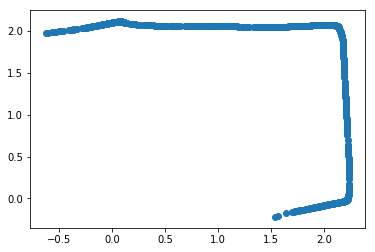

In [3]:
# samples = [gan.sample_images(i) for i in np.linspace(-2, 2, 1000)]
samples = [gan.sample_images(np.random.normal()) for i in np.linspace(-2, 2, 1000)]
samples = np.vstack(samples)

plt.figure()
plt.scatter(samples[:,0], samples[:,1]);

In [4]:
from tqdm import tqdm
import random
def sample_toy_distr():
    x = np.random.normal(0, 0.1)
    y = np.random.normal(0, 0.1)
    centers = [(0,2),  (2,0), (2,2)]
    mu_x, mu_y = random.sample(centers,1)[0]
    return [x + mu_x, y + mu_y]

r_samples = [sample_toy_distr() for i in tqdm(np.linspace(-1, 1, 10000))]
r_samples = np.vstack(r_samples)

100%|██████████| 10000/10000 [00:00<00:00, 34576.54it/s]


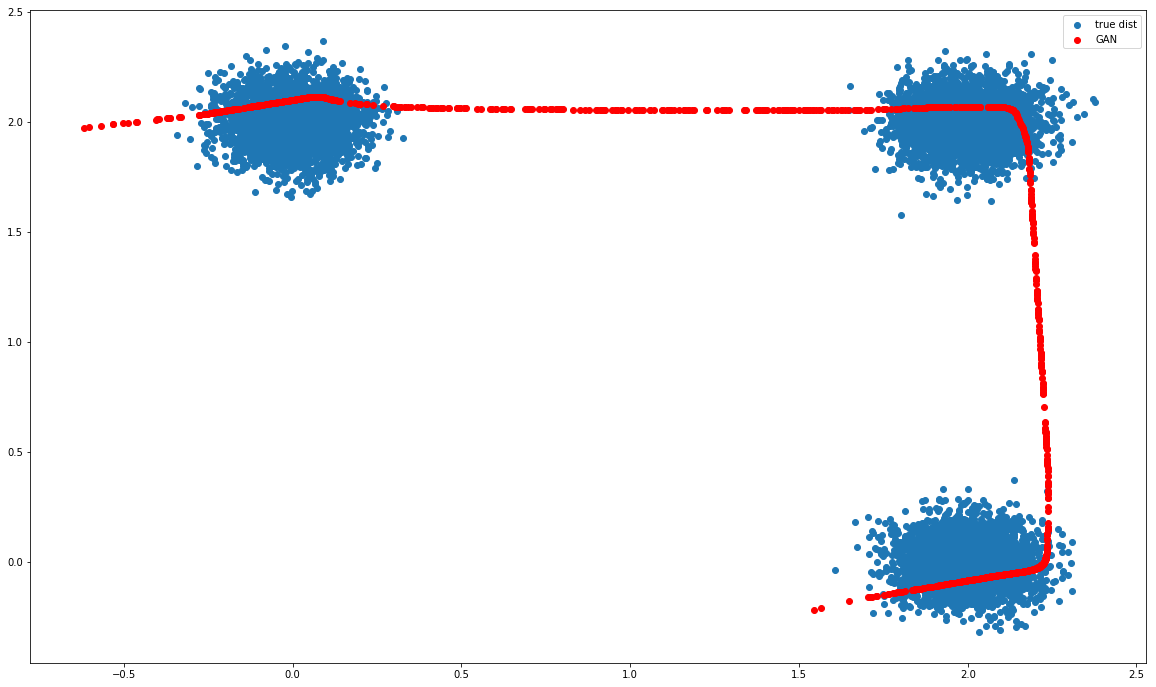

In [5]:
plt.figure(figsize=(20,12))
plt.scatter(r_samples[:,0], r_samples[:,1], label='true dist')
plt.scatter(samples[:,0], samples[:,1], c='r', label='GAN');
plt.legend();